# Superbolts

Exploring data from the World Wide Lightning Location Network (WWLLN).

Allen Downey

[MIT License](https://mit-license.org/)

In [1]:
# Install empiricaldist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py"
)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import decorate

## Load the data

Thanks to Professors Robert Holzworth and Michael McCarthy for providing this data from Figure 2 of ["Global Distribution of Superbolts"](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2019JD030975).

In [4]:
download(
    "https://raw.githubusercontent.com/AllenDowney/ProbablyOverthinkingIt/book/examples/SB2019rawCounts.txt"
)

In [5]:
binned = pd.read_csv("SB2019rawCounts.txt", sep="\t", header=None)
binned.head()

,0,1,2
0,10.00,11.13,949197
1,11.13,12.40,599878
2,12.40,13.80,705316
3,13.80,15.37,818835
4,15.37,17.11,955340


Place each point in the logarithmic center of its bin.

In [6]:
log_center = (np.log10(binned[0]) + np.log10(binned[1])) / 2
log_center.describe()

count    150.000000
mean       4.499997
std        2.027455
min        1.023248
25%        2.761667
50%        4.500000
75%        6.238333
max        7.976667
dtype: float64

Make a PMF.

In [23]:
from empiricaldist import Pmf

ps = binned[2].values
pmf2 = Pmf(ps, index=log_center)
n = pmf2.sum()
n

1077038042

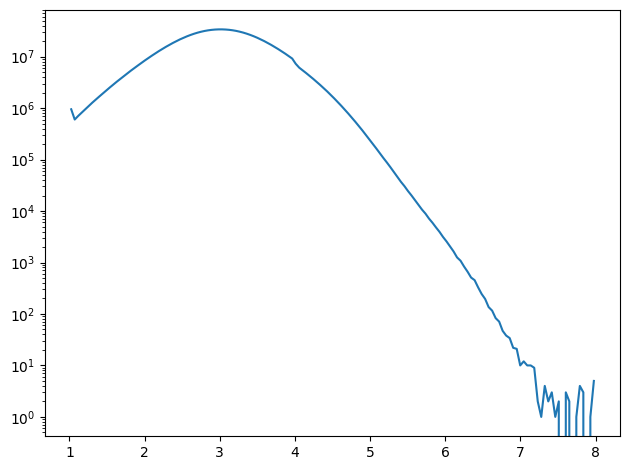

In [9]:
pmf2.plot()
decorate(yscale="log")

Make a tail distribution (a nonstandard survival curve that represents the fraction of strokes with energy greater than *or equal to* each value of x, rather than strictly greater).

In [10]:
from empiricaldist import Surv

pmf2.normalize()
surv = Surv(pmf2.make_surv() + pmf2)

In [11]:
xlabel = "Energy (log10 J)"
ylabel = "Prob >= $x$"

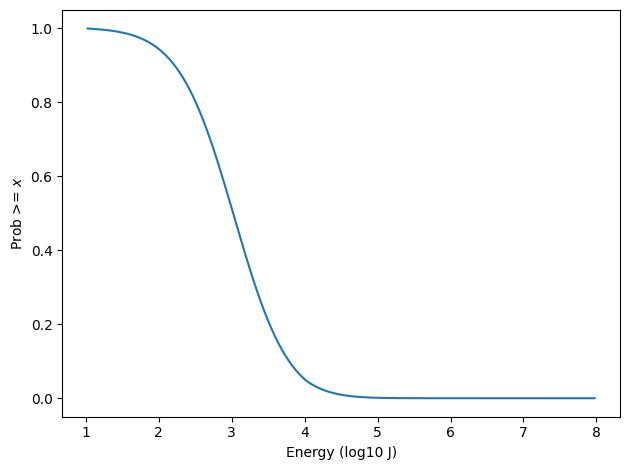

In [12]:
surv.plot()

decorate(xlabel=xlabel, ylabel=ylabel)

## Fit a Gaussian

Find the Gaussian that best matches percentiles with the data.

In [14]:
from empiricaldist import Pmf
from scipy.stats import norm


def truncated_normal_sf(qs, mu, sigma):
    ps = norm.sf(qs, mu, sigma)
    surv_model = Surv(ps / ps[0], qs)
    return surv_model

In [15]:
from scipy.optimize import least_squares


def fit_truncated_normal(surv):
    low, high = surv.qs.min(), surv.qs.max()
    qs_model = np.linspace(low, high, 1000)

    # match 20 percentiles from 1st to 99th
    ps = np.linspace(0.1, 0.99, 20)
    qs = surv.inverse(ps)

    def error_func(params):
        mu, sigma = params

        sf_model = truncated_normal_sf(qs_model, mu, sigma)
        error = surv(qs) - sf_model(qs)
        return error

    params = surv.mean(), surv.std()
    res = least_squares(error_func, x0=params, xtol=1e-3)
    assert res.success
    return res.x

In [16]:
mu, sigma = fit_truncated_normal(surv)
mu, sigma

(3.0127965419077416, 0.6048350889257574)

In [17]:
low, high = surv.qs.min(), surv.qs.max()
qs = np.linspace(low, high, 2000)
surv_model = truncated_normal_sf(qs, mu, sigma)

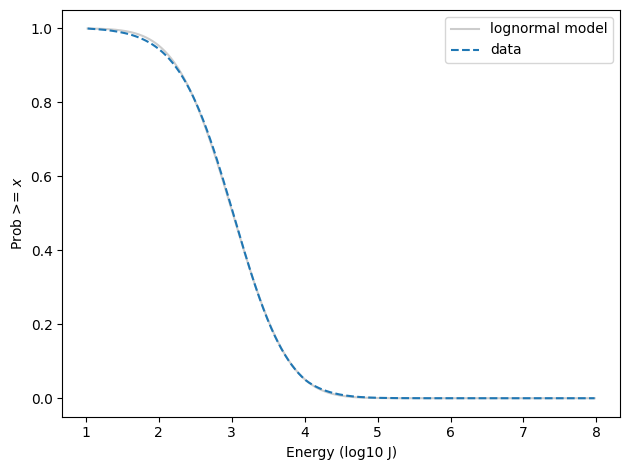

In [18]:
surv_model.plot(color="gray", alpha=0.4, label="lognormal model")
surv.plot(ls="--", label="data")

decorate(xlabel=xlabel, ylabel=ylabel)
plt.savefig("superbolt1.png", dpi=300)

Plot results with error bounds.

In [19]:
from scipy.stats import binom
from utils import underride


def empirical_error_bounds(surv, n, qs, alpha=0.95):
    """Find the bounds on a normal CDF analytically."""
    # find the correct probabilities
    ps = surv.make_cdf()(qs)

    # find the upper and lower percentiles of
    # a binomial distribution
    p_low = (1 - alpha) / 2
    p_high = 1 - p_low

    low = binom.ppf(p_low, n, ps) / n
    low[ps == 1] = 1
    high = binom.ppf(p_high, n, ps) / n
    return 1 - low, 1 - high

In [20]:
def plot_error_bounds(surv, n, **options):
    underride(options, linewidth=0, alpha=0.1, capstyle="round")
    qs = np.linspace(surv.qs.min(), surv.qs.max(), 100)
    low, high = empirical_error_bounds(surv, n, qs)

    plt.fill_between(qs, low, high, **options)

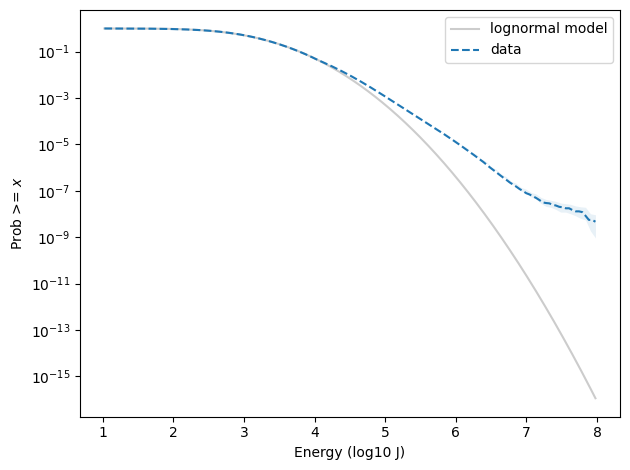

In [24]:
surv_model.plot(color="gray", alpha=0.4, label="lognormal model")
surv.plot(ls="--", label="data")

plot_error_bounds(surv, n, color="C0")

decorate(xlabel=xlabel, ylabel=ylabel, yscale="log")
plt.savefig("superbolt2.png", dpi=300)

Evaluating the empirical survival function and the model, we see that at magnitude 7.9, the model is off by about 7 orders of magnitude.

In [35]:
surv(7.9), surv_model(7.9)

(array(5.57083391e-09), array(2.54468997e-09))

## Fit a Student t

Find the df parameter that best matches the tail, then the mu and sigma parameters that best match the percentiles.

In [26]:
from scipy.stats import t as t_dist


def truncated_t_sf(qs, df, mu, sigma):
    ps = t_dist.sf(qs, df, mu, sigma)
    surv_model = Surv(ps / ps[0], qs)
    return surv_model

In [27]:
from scipy.optimize import least_squares


def fit_truncated_t(df, surv):
    """Given df, find the best values of mu and sigma."""
    low, high = surv.qs.min(), surv.qs.max()
    qs_model = np.linspace(low, high, 1000)

    # match 20 percentiles from 1st to 99th
    ps = np.linspace(0.01, 0.9, 20)
    qs = surv.inverse(ps)

    def error_func_t(params, df, surv):
        mu, sigma = params
        surv_model = truncated_t_sf(qs_model, df, mu, sigma)

        error = surv(qs) - surv_model(qs)
        return error

    params = surv.mean(), surv.std()
    res = least_squares(error_func_t, x0=params, args=(df, surv), xtol=1e-3)
    assert res.success
    return res.x

In [28]:
from scipy.optimize import minimize


def minimize_df(df0, surv, bounds=[(1, 1e6)], ps=None):
    low, high = surv.qs.min(), surv.qs.max()
    qs_model = np.linspace(low, high * 1.0, 2000)

    if ps is None:
        t = surv.ps[0], surv.ps[-2]
        t = 0.1, surv.ps[-2]
        low, high = np.log10(t)
        ps = np.logspace(low, high, 30, endpoint=False)

    qs = surv.inverse(ps)

    def error_func_tail(params):
        (df,) = params
        mu, sigma = fit_truncated_t(df, surv)
        surv_model = truncated_t_sf(qs_model, df, mu, sigma)

        errors = np.log10(surv(qs)) - np.log10(surv_model(qs))
        return np.sum(errors**2)

    params = (df0,)
    res = minimize(error_func_tail, x0=params, bounds=bounds, tol=1e-3, method="Powell")
    assert res.success
    return res.x

Search for the value of df that best matches the tail behavior.

In [29]:
df = minimize_df(5, surv, [(1, 1000)])
df

array([28.49482247])

Given that value of df, find mu and sigma to best match percentiles.

In [30]:
mu, sigma = fit_truncated_t(df, surv)
df, mu, sigma

(array([28.49482247]), 3.0120077516499237, 0.5934553421116102)

Run the model out to magnitude 8.

In [31]:
# low, high = surv.qs.min(), surv.qs.max()
low, high = surv.qs.min(), 8
qs = np.linspace(low, high, 2000)
surv_model = truncated_t_sf(qs, df, mu, sigma)

On a linear scale, the model looks pretty good.

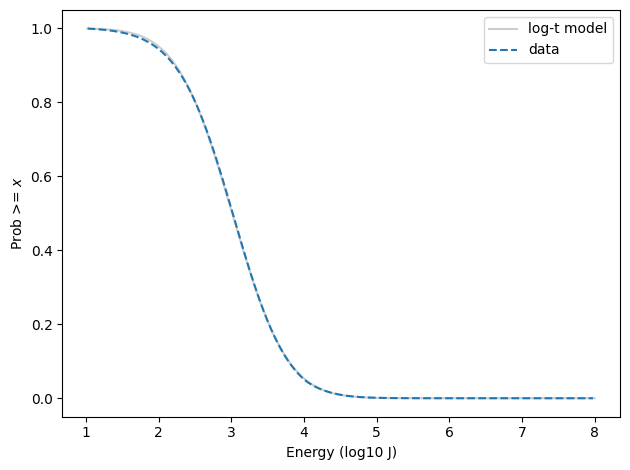

In [32]:
surv_model.plot(color="gray", alpha=0.4, label="log-t model")
surv.plot(ls="--", label="data")

decorate(xlabel=xlabel, ylabel=ylabel)
plt.savefig("superbolt3.png", dpi=300)

On a log scale we can see that it matches the tail behavior much better than the Gaussian model.

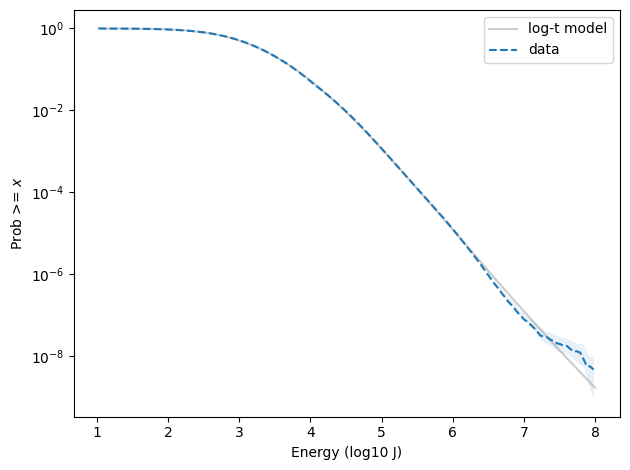

In [34]:
surv_model.plot(color="gray", alpha=0.4, label="log-t model")
surv.plot(ls="--", label="data")

plot_error_bounds(surv, n, color="C0")

decorate(xlabel=xlabel, ylabel=ylabel, yscale="log")
plt.savefig("superbolt4.png", dpi=300)